[View in Colaboratory](https://colab.research.google.com/github/zhongqin0820/Misc-Algorithm-Implement/blob/master/Colab/xgboost_boston.ipynb)

# 环境配置

## ~~安装kaggle依赖~~
不需要这个环节

In [0]:
!pip install -U -q kaggle

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

### 下载boston数据集

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p /content/kaggle

In [0]:
!ls /content/kaggle # list the content in /content/kaggle

## 安装xgboost依赖
- xgboost
- sklearn
- matplotlib
- numpy
- pandas

In [0]:
!pip install -U -q xgboost sklearn matplotlib numpy pandas

In [0]:
from sklearn.datasets import load_boston
boston = load_boston()

加载的boston数据是一个字典，`data`是数据字段，`target`是标签字段，`feature_names`是`data`对应的标签描述，`DESCR`是数据集合的描述

In [3]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [4]:
print(boston.data.shape)

(506, 13)


In [5]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [0]:
print(boston.DESCR)

### 将sklearn中的数据转换成pandas中的dataframe

并使用`boston.feature_names`指定数据对应的标签描述`data.colums`

In [0]:
import pandas as pd

In [0]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [11]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [0]:
data['PRICE']=boston.target

### 分析你的而数据
- `info()`查看整体的情况，包括是否有空值以及条目

- `describe()`则更详细的查看各个特征的值

如果出现空值或者缺省值等，可以参考这个[链接](https://github.com/dmlc/xgboost/issues/21)

In [13]:
data.info() # to get useful information about the data (:type: DataFrame)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [14]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# 模型训练

## 初始化训练环境

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [0]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]

### 将pandas数据转换成xgboost中的DMatrix

In [0]:
data_dmtrix = xgb.DMatrix(data=X, label=y)

### xgboost中的一些超参
注意你使用的`base learner`是什么(`gbtree`、`gblinear`、`dart`)

#### 常规参数
- `learning_rate`：范围`[0,1]`
- `max_depth`：树深
- `subsample`：每棵树的样例数
- `colsample_bytree`：每棵树的特征数，设置太大容易引起过拟合
- `n_estimators`：树的棵树
- `objective`：目标学习器（包括：`reg:linear`，`reg:logistic`以及`binary:logistic`）

#### 正则化参数
- `gamma`：控制给定节点是否继续分裂，只支持`tree-based`学习器。较高的值会导致较少的分裂。
- `alpha`：L1正则项
- `lambda`：L2正则项

### 划分训练数据集
分为：训练数据集与验证集(下面的例子是`4:1`)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 构造学习器
- 回归问题可以使用`XGBRegressor()`
- 分类问题可以使用`XGBClassifier()`

In [0]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bylevel=0.3, learning_rate=0.1,max_depth=5,alpha=10,n_estimators=10)

## `fit`数据

In [0]:
xg_reg.fit(X_train, y_train) # training
preds = xg_reg.predict(X_test) # testing

## 评估模型

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE: %f' % (rmse))

RMSE: 9.701913


# 使用XG Boost进行k-折交叉验证

**each entry is used for validation just once**

在XG Boost中使用`cv()`进行交叉验证训练模型提升性能

## 支持的一些参数

- `nfolds`：指定交叉验证的集合数
- `num_boost_round`：树的数目
- `metrics`：性能验证指标
- `as_pandas`：结果使用pandas里的DataFrame进行表示
- `early_stopping_rounds`：停止准则
- `seed`：复现结果时指定的种子

**一般来说，我们会指定一个超参字典`params`**

In [0]:
params = {'objective': 'reg:linear', 'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv( dtrain=data_dmtrix, params=params, nfold=3,
                   num_boost_round=50, early_stopping_rounds=10, metrics='rmse',
                   as_pandas=True, seed=123 )

## 查看结果

In [25]:
cv_results.head()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,21.746693,0.019311,21.749371,0.033853
1,19.891096,0.053295,19.859423,0.029633
2,18.168509,0.014465,18.072169,0.018803
3,16.687861,0.037342,16.570206,0.018556
4,15.365013,0.059400,15.206344,0.015451


In [27]:
print((cv_results['test-rmse-mean']).tail(1))

49    4.031162
Name: test-rmse-mean, dtype: float64


# 可视化树和特征权重

In [0]:
xg_reg = xgb.train(dtrain=data_dmtrix, params=params, num_boost_round=10)

In [0]:
import matplotlib.pyplot as plt

## 安装可视化依赖

In [0]:
!apt-get install graphviz
!pip install graphviz

## 可视化树

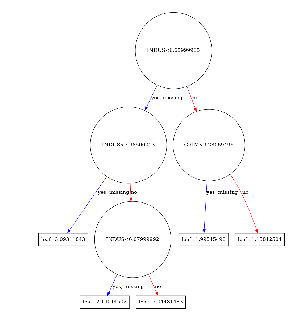

In [32]:
xgb.plot_tree(xg_reg, num_trees=0 )
plt.rcParams['figure.figsize']=[50,10]
plt.show()

## 可视化特征权重

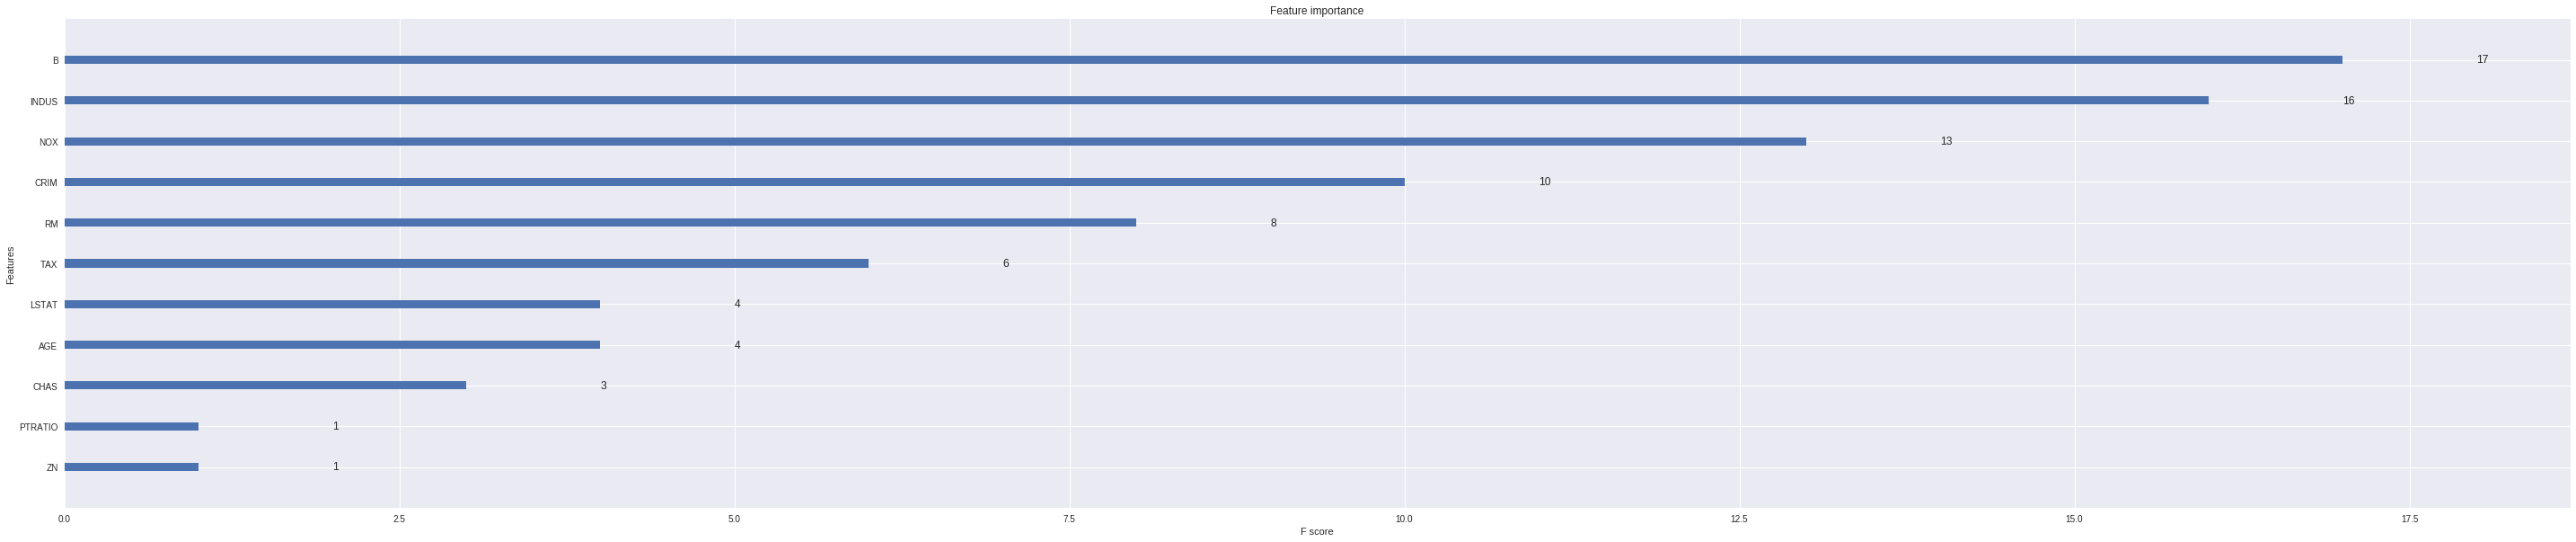

In [33]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize']=[5,5]
plt.show()

# 结束语
实践出真知系列...

[参考链接](https://www.datacamp.com/community/tutorials/xgboost-in-python)